In [1]:
#import models
import numpy as np
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
import time 
from tqdm.auto import tqdm


In [4]:
events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []
contact_angle = []

contact_case_updated = []
contact_case_updated_ts = []

event_packet_size = []
event_packet_size_ts = []
contact_angle = []

#[math.radians(i) for i in range(1,11)]#

#generate label
possible_angle = [math.radians(i) for i in range(1,11)]#[0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 20
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)

191
[[0, 0, 0], [0.016507624989807086, 0.00566707481709966, 0], [0.03301524997961417, 0.01133414963419932, 0], [0.04952287496942126, 0.017001224451298983, 0], [0.06603049995922834, 0.02266829926839864, 0], [0.08253812494903542, 0.0283353740854983, 0], [0.09904574993884252, 0.034002448902597966, 0], [0.1155533749286496, 0.03966952371969762, 0], [0.13206099991845668, 0.04533659853679728, 0], [0.14856862490826378, 0.05100367335389694, 0], [0.16507624989807085, 0.0566707481709966, 0], [0.013773100149832318, 0.01072003414404066, 0], [0.027546200299664637, 0.02144006828808132, 0], [0.04131930044949696, 0.03216010243212198, 0], [0.05509240059932927, 0.04288013657616264, 0], [0.06886550074916159, 0.053600170720203295, 0], [0.08263860089899391, 0.06432020486424396, 0], [0.09641170104882622, 0.07504023900828462, 0], [0.11018480119865855, 0.08576027315232528, 0], [0.12395790134849086, 0.09648030729636593, 0], [0.13773100149832318, 0.10720034144040659, 0], [0.009546046196954917, 0.0146113114330066

In [26]:
12*(2*4+1)

108

In [27]:
12*(10*19+1)

2292

In [4]:
import pandas as pd

df = pd.read_csv('parsed_bag2.csv')

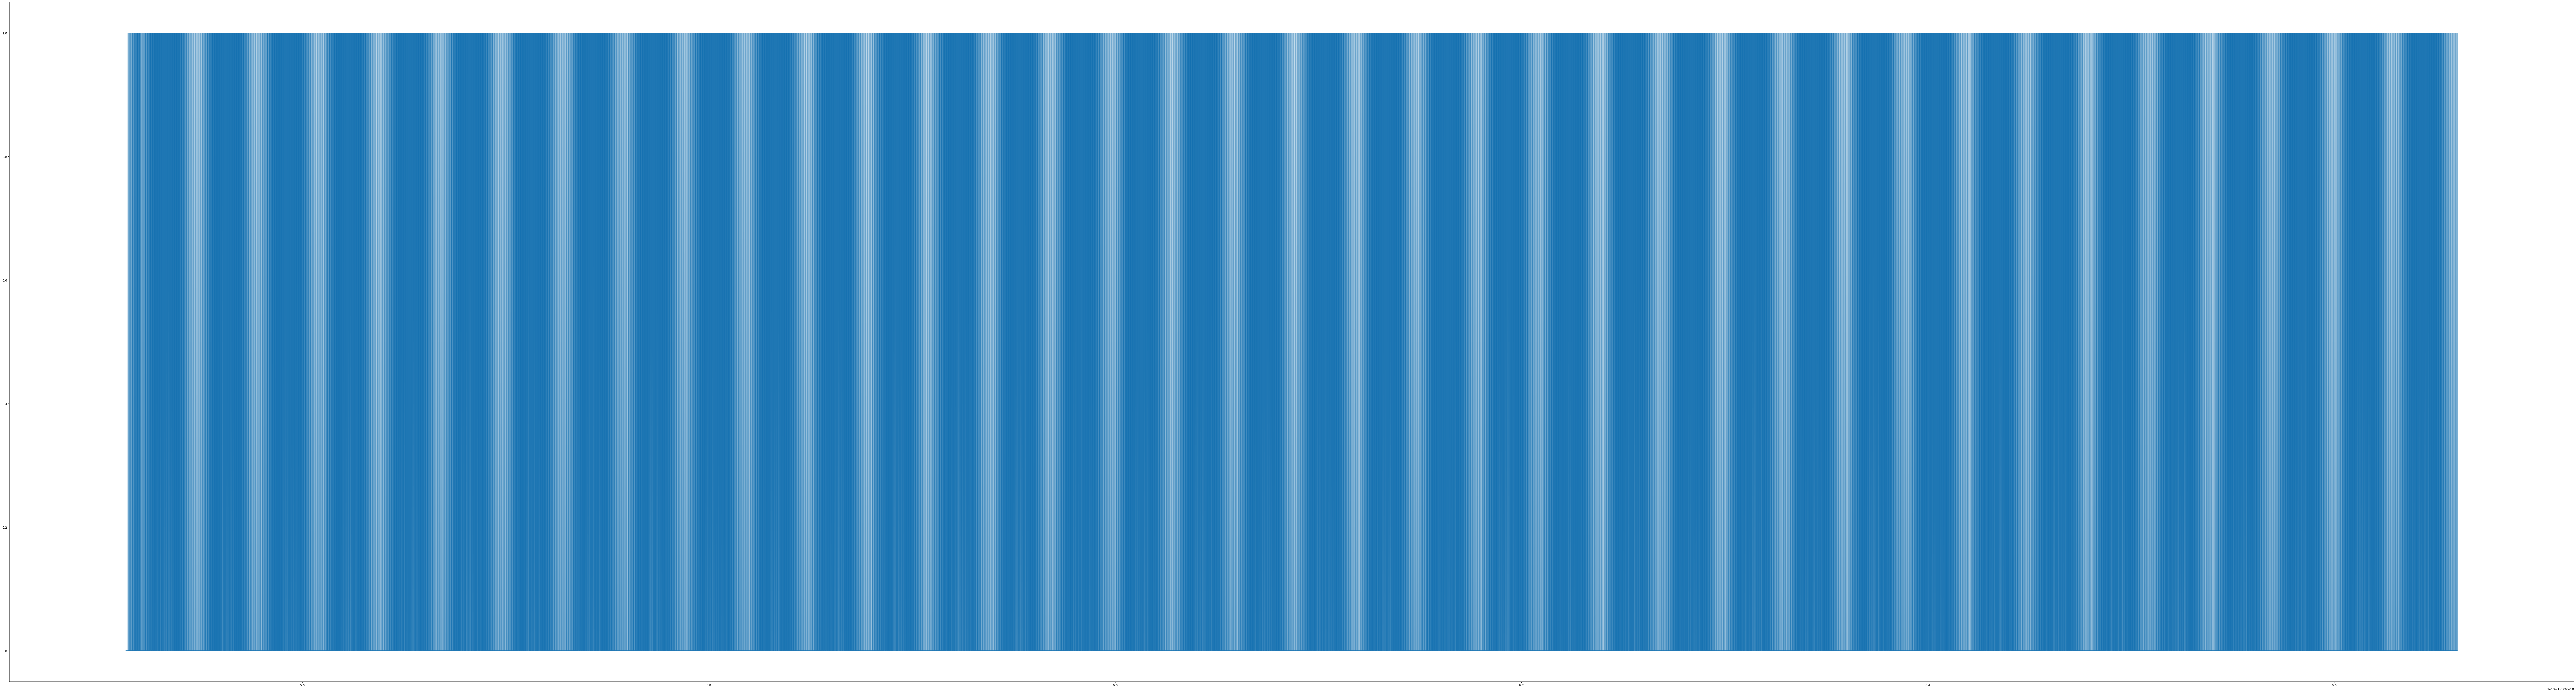

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(150, 40))
plt.plot(df['ts'], df['contact_status'])

In [14]:
def find_case(idx):
    if not df['contact_status'][idx]:
        return 0
    else:
        best_rot_diff = 100
        best_rot_idx = 1
        i = 1
        x, y, z = df[['contact_angle_x', 'contact_angle_y', 'contact_angle_z']].iloc[idx]
        for rot in list_of_rotations:
            diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
            if best_rot_diff > diff_vals:
                best_rot_diff = diff_vals
                best_rot_idx = i
            i = i + 1
        return best_rot_idx


In [5]:

plt.figure(figsize=(350, 40))
plt.plot(df['ts'], df['contact_case'])


In [7]:
import h5py
import dask.array as da

h5_arr = h5py.File('new_events.h5', 'r')
events = da.array(h5_arr['events'])
events

dask.array<array, shape=(89565950, 4), dtype=int64, chunksize=(4194302, 4), chunktype=numpy.ndarray>

In [8]:
case_span = 2.66e9
find_ts_idx = lambda ts: np.searchsorted(df['ts'], ts)

def look_ahead_big(ts, idx_ts):
    fin_ts = ts + case_span
    fin_idx = find_ts_idx(fin_ts)
    print(fin_idx)
    if df['contact_status'][fin_idx]:
        #look further
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ += 1
            if fin_idx_ - fin_idx > 25:
                print('warning more than 25 idx away from init_ts + case_span')
            if df['contact_status'][fin_idx_]:
                continue
            else:
                more = False
        print(f'was before case ended by {fin_idx_ - fin_idx} indexes')
        fin_idx = fin_idx_ - 1
    else:
        #look backwards
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ -= 1
            if not df['contact_status'][fin_idx_]:
                continue
            else:
                more = False
        print(f'was ahead case ended by {fin_idx - fin_idx} indexes')
        fin_idx = fin_idx_ + 1
        
    return df['ts'][fin_idx]


def find_case(ts):
    idx = find_ts_idx(ts)
    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    x, y, z = df[['contact_angle_x', 'contact_angle_y', 'contact_angle_z']].iloc[idx]
    for rot in list_of_rotations:
        diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    return best_rot_idx


i = 0 
cases_ts = []
cases_idx = []
cases = []
pbar = tqdm(total=len(df['contact_status']), desc='extracting contact timestamps')

while i < len(df['contact_status']):
    if df['contact_status'][i]:
        init_ts = df['ts'][i]
        fin_ts = look_ahead_big(init_ts, i)
        fin_idx = find_ts_idx(fin_ts)
        case = find_case(np.mean([init_ts, fin_ts]))
        
        cases.append(case)
        cases_ts.append([init_ts, fin_ts])
        cases_idx.append([i, fin_idx])
        print(len(cases_ts), init_ts, fin_ts, (fin_ts - init_ts)*1e-9, i, fin_idx, case, '\n')
        i = fin_idx + 1
        pbar.update(fin_idx + 1 - i)

    else:
        i += 1
        pbar.update(1)

extracting contact timestamps:   0%|          | 0/450596 [00:00<?, ?it/s]

497
was ahead case ended by 0 indexes
1 1672655140251090003 1672655142456184752 2.205094749 394 478 1 

699
was ahead case ended by 0 indexes
2 1672655145264756334 1672655147471442768 2.2066864340000003 592 682 1 

906
was ahead case ended by 0 indexes
3 1672655150260753111 1672655152430891037 2.170137926 795 885 1 

1103
was ahead case ended by 0 indexes
4 1672655155316001883 1672655157391913926 2.075912043 1000 1079 1 

1296
was ahead case ended by 0 indexes
5 1672655160295336061 1672655162427514522 2.132178461 1193 1276 1 

1498
was ahead case ended by 0 indexes
6 1672655165285349627 1672655167474914961 2.189565334 1395 1479 1 

1692
was ahead case ended by 0 indexes
7 1672655170280181953 1672655172504369712 2.2241877590000003 1585 1673 1 

1889
was ahead case ended by 0 indexes
8 1672655175284349590 1672655177515156958 2.2308073680000002 1785 1874 1 

2095
was ahead case ended by 0 indexes
9 1672655180262090558 1672655182522844360 2.260753802 1984 2080 1 

2294
was ahead case ended

(array([  4.,   9.,   5.,   0.,   0.,   1.,  72., 623., 903., 675.]),
 array([1.35430172e+09, 1.45198802e+09, 1.54967432e+09, 1.64736062e+09,
        1.74504692e+09, 1.84273322e+09, 1.94041952e+09, 2.03810582e+09,
        2.13579212e+09, 2.23347842e+09, 2.33116472e+09]),
 <BarContainer object of 10 artists>)

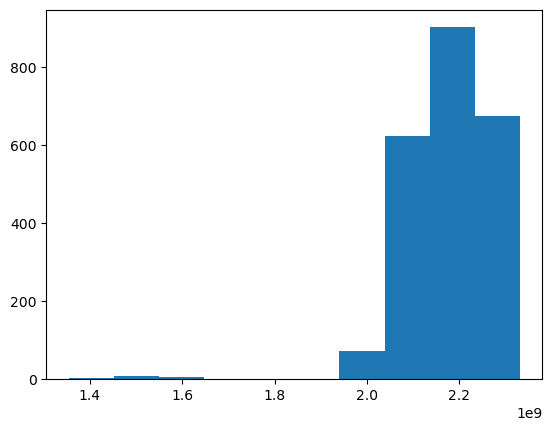

In [9]:
plt.hist([i[1]-i[0] for i in cases_ts])

(array([  4.,   8.,   7.,  11.,  86., 284., 696., 659., 450.,  87.]),
 array([53. , 57.5, 62. , 66.5, 71. , 75.5, 80. , 84.5, 89. , 93.5, 98. ]),
 <BarContainer object of 10 artists>)

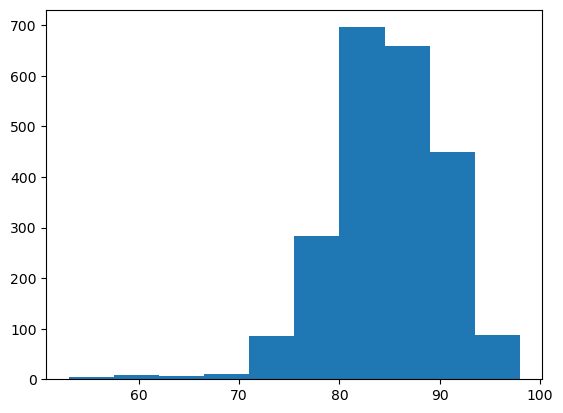

In [10]:
plt.hist([i[1]-i[0] for i in cases_idx])

In [11]:
def ev_ts2idx(ts, guess_idx, init_stepsize=50000):
    stepsize = init_stepsize
    search_sorted = lambda st: da.searchsorted(events[guess_idx:guess_idx+st, 2], da.array([ts])).compute()[0]
    n_iters = 0
    
    out = search_sorted(stepsize)
    
    while out == stepsize:
        n_iters += 1
        stepsize = 10*stepsize
        
        out = search_sorted(stepsize)
    if n_iters > 1:
        print(ts, n_iters)
    return out + guess_idx

In [12]:
delta_t = 0.05e9
margin = 0#-0.025e9
dist_from_center = lambda x, y: np.sqrt((x - 180)**2 + (y - 117)**2)
circle_rad=85

event_arrays = []
ev_idx_init = []
label_contact_case = []

guess_idx = 0

for i, idx in enumerate(tqdm(cases_idx)):
    init_ts_idx = ev_ts2idx(cases_ts[i][0] + margin, guess_idx)
    ev_idx_init.append(init_ts_idx)
    guess_idx = init_ts_idx
    fin_ts_idx = ev_ts2idx(cases_ts[i][0] + delta_t, guess_idx)#da.searchsorted(events[:, 2], da.array([cases_ts[i][0] + delta_t]))
    guess_idx = fin_ts_idx
    if fin_ts_idx - init_ts_idx + 1 < 750:
        continue    
    else:
        event_array = events[init_ts_idx:fin_ts_idx+1].compute()

    in_circle = dist_from_center(event_array[:, 0], event_array[:, 1]) < circle_rad  
    event_arrays.append(event_array[in_circle, :])
    label_contact_case.append(cases[i])

  0%|          | 0/2292 [00:00<?, ?it/s]

(array([11.,  9., 12., 12., 12., 12., 12., 12., 12., 12., 12., 10., 11.,
        12., 12., 12., 12., 12., 12., 12., 12.,  8., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 11., 12., 12.,
        12., 12.,  9., 11., 12., 12., 12., 12., 12., 11., 12., 12., 12.,
        10., 10., 10., 12., 12., 12., 12., 12., 11., 11., 12., 12., 11.,
        12., 12., 12., 12., 12., 12., 12., 11., 12., 12., 12., 12., 12.,
        12., 12., 12., 11.,  9., 12., 12., 11., 12., 12., 12., 12., 12.,
        12., 10., 12., 12., 12., 12., 12., 12., 12., 12., 11., 10., 12.,
        10., 12., 11., 12., 12., 12., 12., 11., 11., 11., 10., 10., 12.,
        11., 12., 12., 12., 10.,  9., 11., 10., 11., 11., 12., 12., 12.,
        12., 11., 11., 11., 10., 11., 11., 12., 12., 12., 12., 10., 11.,
         9.,  9., 12., 12., 11., 12., 12., 12., 10.,  9.,  9., 11., 11.,
        11., 12., 12., 12., 12., 10., 10., 10.,  9.,  9., 12., 12., 12.,
        12., 12., 10.,  9.,  9., 12., 12.,  9., 12.

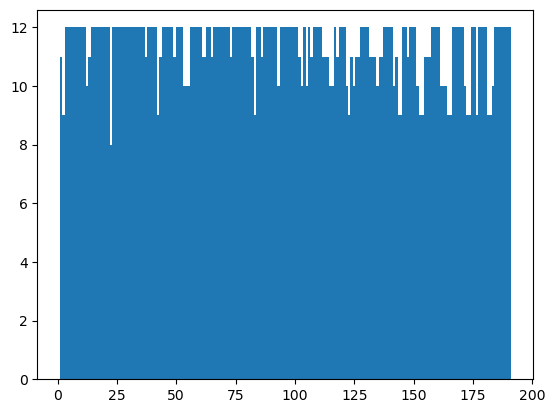

In [13]:
plt.hist(label_contact_case, bins=191)

(4178, 4)

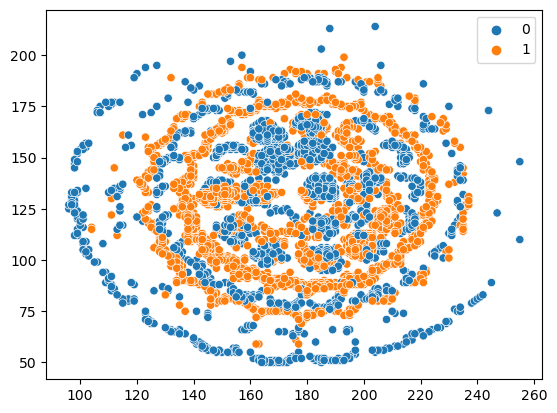

In [14]:
import seaborn as sns

idx = 100
plt.figure
sns.scatterplot(x=event_arrays[idx][:, 0], y=250-event_arrays[idx][:, 1], hue=event_arrays[idx][:, 3])
event_arrays[idx].shape

In [ ]:
cases_dict

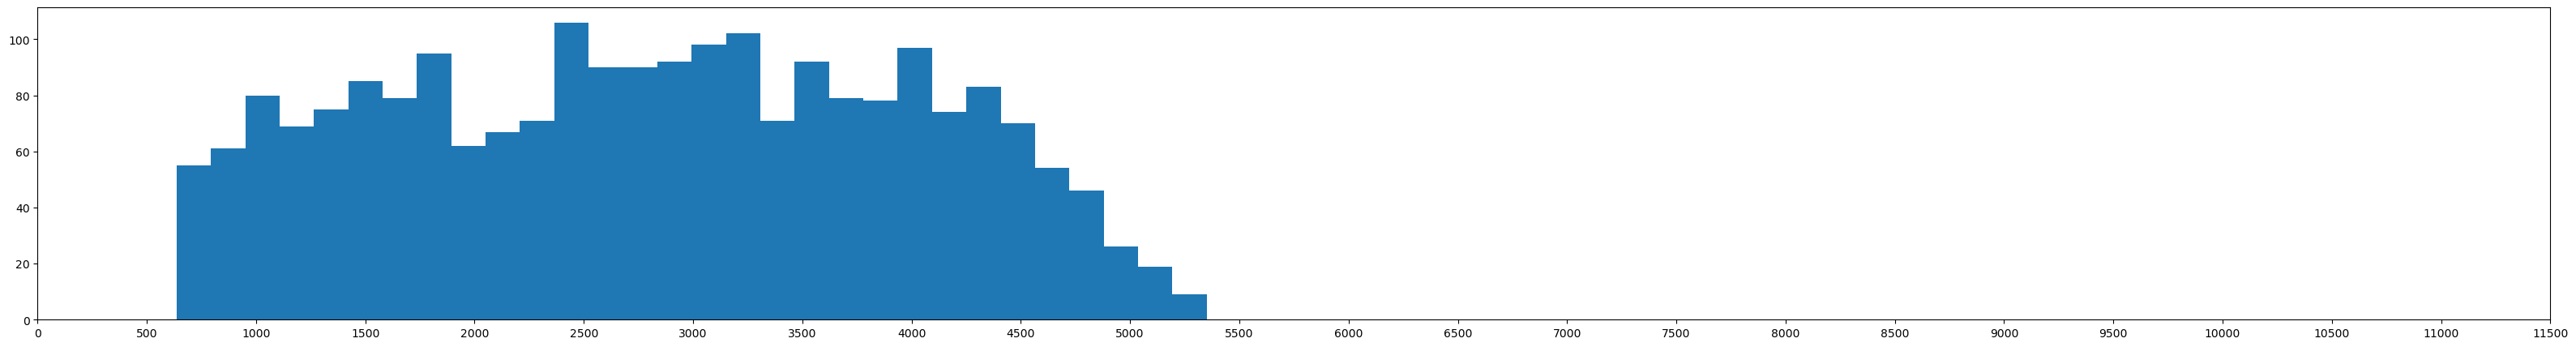

In [15]:
plt.figure(figsize=(40, 5))
plt.hist([i.shape[0] for i in event_arrays], bins=30)
plt.xticks(np.arange(12000, step=500));

In [16]:
samples={}

gen = zip(label_contact_case, event_arrays) 
for i, (case, event_array) in enumerate(gen):
    samples[f'sample_{i+1}'] = {
        'events': event_array.tolist(),
        'case': case
        }


In [18]:
from pathlib import Path
import json

EXTRACTIONS_DIR = Path('./data/extractions/').resolve()
outdir = EXTRACTIONS_DIR / 'contact_extraction3'

if not outdir.exists():
    outdir.mkdir(parents=True)
    

with open(outdir / 'samples.json', 'w') as f:
    json.dump(samples, f, indent=4)

In [ ]:
from sklearn.model_selection import train_test_split


sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.7, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=0) #fixed across extractions

print(len(train_idx), len(val_idx), len(test_idx))
subsets = zip(['train', 'test', 'val'], [train_idx, val_idx, test_idx])

if not outdir.exists():
    outdir.mkdir(parents=True)

for sub_name, subset in subsets:
    if not (outdir / sub_name).exists():
        (outdir / sub_name / 'raw').mkdir(parents=True)
        (outdir / sub_name / 'processed').mkdir(parents=True)
    with open(outdir / sub_name / 'raw' / 'contact_cases.json', 'w') as f:
        subset_samples = {}
        for i, subset_idx in enumerate(subset):
            sample = samples[subset_idx]
            sample['total_idx'] = subset_idx
            subset_samples[f'sample_{i+1}'] = sample
        json.dump(subset_samples, f, indent=4)

1522 326 327


In [2]:
from __future__ import division
import os.path as osp
import glob
import torch
import torch_geometric.transforms as T
import os
import json 
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch.utils.data
from torch_geometric.data import Data, DataLoader, Dataset

import numpy as np

import torch
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from collections.abc import Sequence

import os.path as osp
from pathlib import Path

import torch
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.nn.pool import radius_graph, knn_graph
from torch_geometric.utils import remove_isolated_nodes

In [5]:
cases_dict = {i+1: list_of_rotations[i][:2] for i in range(len(list_of_rotations))}
cases_dict[0] = [0, 0]
cases_dict

{1: [0, 0],
 2: [0.016507624989807086, 0.00566707481709966],
 3: [0.03301524997961417, 0.01133414963419932],
 4: [0.04952287496942126, 0.017001224451298983],
 5: [0.06603049995922834, 0.02266829926839864],
 6: [0.08253812494903542, 0.0283353740854983],
 7: [0.09904574993884252, 0.034002448902597966],
 8: [0.1155533749286496, 0.03966952371969762],
 9: [0.13206099991845668, 0.04533659853679728],
 10: [0.14856862490826378, 0.05100367335389694],
 11: [0.16507624989807085, 0.0566707481709966],
 12: [0.013773100149832318, 0.01072003414404066],
 13: [0.027546200299664637, 0.02144006828808132],
 14: [0.04131930044949696, 0.03216010243212198],
 15: [0.05509240059932927, 0.04288013657616264],
 16: [0.06886550074916159, 0.053600170720203295],
 17: [0.08263860089899391, 0.06432020486424396],
 18: [0.09641170104882622, 0.07504023900828462],
 19: [0.11018480119865855, 0.08576027315232528],
 20: [0.12395790134849086, 0.09648030729636593],
 21: [0.13773100149832318, 0.10720034144040659],
 22: [0.00954

In [6]:
def files_exist(files):
    return all([osp.exists(f) for f in files])

im_height=260
im_width=346

class TactileDataset(Dataset):
    """_summary_

        Args:
            root (_type_): _description_
            transform (_type_, optional): _description_. Defaults to None.
            pre_transform (_type_, optional): _description_. Defaults to None.
            features (str, optional): _description_. Defaults to 'all'.
            reset (bool, optional): _description_. Defaults to False.
    """

    def __init__(self, root, transform=None, pre_transform=None, features='all', reset=False, augment=False):
        """_summary_

        Args:
            root (_type_): _description_
            transform (_type_, optional): _description_. Defaults to None.
            pre_transform (_type_, optional): _description_. Defaults to None.
            features (str, optional): _description_. Defaults to 'all'.
            reset (bool, optional): _description_. Defaults to False.
        """
        if reset:
            print('rm -rf ' + root + '/processed')
            ret=os.system('rm -rf ' + root + '/processed')
        root = Path(root)

        assert features in ['pol', 'coords', 'all', 'pol_time']
        self.features = features

        self.augment = augment
        super(TactileDataset, self).__init__(root, transform, pre_transform)
        self._indices = None
        
    def indices(self) -> Sequence:
        return range(self.len()) if self._indices is None else self._indices

    @property
    def raw_file_names(self):
        filenames = os.path.join(self.raw_dir, 'contact_cases.json')
        file = [f.split('/')[-1] for f in filenames]
        #print(file)
        return file

    @property
    def processed_file_names(self):
        #glob.glob(os.path.join(self.raw_dir,'../processed/', '*_.pt'))
        filenames = glob.glob(str(self.root / 'processed' / 'sample_*.pt'))
        file = [f.split('/')[-1] for f in filenames]
        saved_file = [f.replace('.pt','.pt') for f in file]
        return saved_file

    def __len__(self):
        return len(self.processed_file_names)

    def indices(self) -> Sequence:
        return range(self.__len__()) if self._indices is None else self._indices

    def sample_generator(self, samples_):
        for key, sample in samples_.items():
            case = sample['case']
            event_array = np.array(sample['events'])
            if not self.augment:
               yield case, event_array 
            else:
                for angle in [0, 90, 180, 270]:
                    if angle == 0:
                        yield case, event_array
                    else:
                        yield rotate_case(event_array, case, angle)

    def process(self):
        knn = 32
        with open(self.root / 'raw' / 'contact_cases.json', 'r') as f:
            samples_ = json.load(f)

        samples = samples_
        if self.augment:
            samples = {}
            for i, (case, event_array) in enumerate(self.sample_generator(samples_)):
                samples[f'sample_{i+1}'] = {
                    'events': event_array,
                    'case': case
                }
                

        for sample_id in samples.keys():
            events = np.array(samples[sample_id]['events'])

            coord1, coord2 = torch.tensor(events[:, 0:2].astype(np.float32)).T 
            ts = events[:, 2]
            ts = ((ts - ts.min()) / (ts.max() - ts.min())).astype(np.float32)
            coord3 = torch.tensor(ts)
            pos = torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T

            if self.features == 'pol':
                feature = torch.tensor(events[:, 3].astype(np.float32))
                feature = feature.view(-1, 1)
            elif self.features == 'coords':
                feature = torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T
            elif self.features == 'pol_time':
                feature = torch.stack((
                    torch.tensor(events[:, 3].astype(np.float32)),
                    coord3 
                )).T
            elif self.features == 'all':
                feature = torch.hstack((
                    torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T, 
                    torch.tensor(events[:, 3].astype(np.float32)).reshape(-1, 1)
                    ))

            case = samples[sample_id]['case']

            #edge_index = radius_graph(pos, r=0.1, max_num_neighbors=10)
            edge_index = knn_graph(pos, knn)
            if self.features == 'pol_time':
                pos = pos[:, :2]

            #edge_index, _, mask = remove_isolated_nodes(edge_index=edge_index, num_nodes=feature.shape[0])

            #print(edge_index, sum(mask))
            #print(mask.shape, data.x.shape, data.edge_index.shape)
            
            pseudo_maker = T.Cartesian(cat=False, norm=True)
            

            y = torch.tensor(np.array(cases_dict[case], dtype=np.float32)).reshape(1, -1)

            data = Data(x=feature, edge_index=edge_index, pos=pos, y=y)
            data = pseudo_maker(data)

            if self.pre_filter is not None and not self.pre_filter(data):
                    continue

            if self.pre_transform is not None:
                    data = self.pre_transform(data)

            torch.save(data, self.root / 'processed' / f'{sample_id}.pt')
        """
        with open(self.root.parent / 'extraction_params.json', 'r') as f:
            params = json.load(f)
        
        params['kNN'] = knn
        params['node_features'] = self.features
        print(params)
        with open(self.root.parent / 'extraction_params.json', 'w') as f:
            json.dump(params, f, indent=4)
        """
            
            

    def get(self, idx):
        # print("I'm in get ", self.processed_dir)

        data = torch.load(osp.join(self.processed_paths[idx]))
        return data

    def load_all_raw(self):
        samples = {}
        for subset in ['train', 'val', 'test']:
            with open(self.root.parent / subset / 'raw' / 'contact_cases.json', 'r') as f:
                subset_samples = json.load(f)
                subset_samples_tot_idx = {item[1]['total_idx']: 
                                        {
                                            'events': item[1]['events'], 
                                            'case': item[1]['case']
                                        } for item in subset_samples.items()}
            
            samples.update(subset_samples_tot_idx)
        return samples

In [13]:
import json
import torch
import torch_geometric as pyg
from tqdm.auto import tqdm, trange  
from pathlib import Path
from numpy import pi
from pandas import DataFrame

class TrainModel():

    def __init__(
        self, 
        extraction_case_dir, 
        model,
        n_epochs = 150,
        optimizer = 'adam',
        lr = 0.001,
        loss_func = torch.nn.L1Loss(),
        transform = None,
        features = 'all',
        weight_decay=0,
        patience=10,
        batch = 1,
        augment=False
        ):

        self.extraction_case_dir = Path(extraction_case_dir)
        self.transform = transform

        self.train_data = TactileDataset(self.extraction_case_dir / 'train', transform=transform, features=features, augment=augment)
        self.val_data = TactileDataset(self.extraction_case_dir / 'val', features=features)
        self.test_data = TactileDataset(self.extraction_case_dir / 'test', features=features)

        self.train_loader = pyg.loader.DataLoader(self.train_data, shuffle=True, batch_size=batch)
        self.val_loader = pyg.loader.DataLoader(self.val_data)
        self.test_loader = pyg.loader.DataLoader(self.test_data)

        self.model = model
        self.n_epochs = n_epochs


        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError('use tm.optimizer = torch.optim.<optimizer>')
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', min_lr=1e-5, patience=patience)

        self.loss_func = loss_func

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        

    def train(self):
        self.train_losses = []
        self.val_losses = []
        self.lr = []

        name = str(type(self.model)).split('.')[-1][:-2]
        path = Path('results') / name

        for epoch in trange(self.n_epochs, desc='training', unit='epoch'):
            #bunny(epoch)
            epoch_loss = 0
            
            if (epoch == 10):
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = 0.001
    
            if epoch == 110:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = 0.0001

            if epoch == 200:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = 0.00001
                    
            lr = self.optimizer.param_groups[0]['lr']
            self.lr.append(lr)
            val_loss = torch.inf
            with tqdm(self.train_loader, unit="batch") as tepoch:
                for i, data in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {epoch}")
                    with torch.autograd.detect_anomaly():
                        data = data.to(self.device)
                        self.optimizer.zero_grad()
                        end_point = self.model(data)
                        loss = self.loss_func(end_point, data.y)
                        loss.backward()
                        self.optimizer.step()
                        lr = self.optimizer.param_groups[0]['lr']

                        epoch_loss += loss.detach().item()
                    
                        tepoch.set_postfix({
                            'train_loss': epoch_loss / (i + 1), 
                            'train_loss_degrees': epoch_loss / (i + 1) * 180/pi, 
                            'val_loss': self.val_losses[epoch - 1] if epoch > 0 else 'na',
                            'val_loss_degrees': self.val_losses[epoch - 1] * 180/pi if epoch > 0 else 'na',
                            'lr': lr
                            })

                #self.scheduler.step(val_loss)
                epoch_loss /= len(self.train_data)
                val_loss = self.validate()
                tepoch.set_postfix({'train_loss': epoch_loss, 'val_loss': val_loss})
                self.train_losses.append(epoch_loss)
                self.val_losses.append(val_loss)
            if (epoch + 1) % 1 == 0:
                self.log(current_epoch=epoch)
        torch.save(self.model, path / 'model.pt')

    def validate(self):
        loss = 0
        for i, data in enumerate(self.val_loader):      
            data = data.to(self.device)
            end_point = self.model(data)

            loss += self.loss_func(end_point, data.y).detach().item()
        loss /= len(self.val_data)
        return loss
    
    def test(self):
        loss = 0
        for i, data in enumerate(self.test_loader):      
            data = data.to(self.device)
            end_point = self.model(data)

            loss += self.loss_func(end_point, data.y).detach().item()
        loss /= len(self.train_data)
        return loss

    def augment(self, batch):
        pass

    def log(self, current_epoch):
        #find model name
        print('logging')
        name = str(type(self.model)).split('.')[-1][:-2]
        path = Path('results') / name
        if not path.exists():
            path.mkdir(parents=True)

        with open(path / 'training_params.json', 'w') as f:
            params = {
                'model': name,
                'extraction_used': str(self.extraction_case_dir),
                'n_epochs': self.n_epochs,
                'final_val_loss_degrees': self.val_losses[-1] * 180 / pi,
            }
            json.dump(params, f, indent=4)

        train_log = { 
            'epoch': [i for i in range(1, current_epoch+2)],
            'train_loss': self.train_losses,
            'val_loss': self.val_losses,
            'lr': self.lr
        }
        DataFrame(train_log).to_csv(path / 'train_log.csv', index=False)



In [15]:
import torch
from torch_geometric.nn import SplineConv, voxel_grid, max_pool, max_pool_x
import torch.nn.functional as F
import torch_geometric.transforms as T

class spline(torch.nn.Module):
    def __init__(self):
        super(spline, self).__init__()
        self.conv1 = SplineConv(1, 64, dim=3, kernel_size=3)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = SplineConv(64, 128, dim=3, kernel_size=3)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = SplineConv(128, 256, dim=3, kernel_size=3)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.conv4 = SplineConv(256, 512, dim=3, kernel_size=3)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.fc1 = torch.nn.Linear(64 * 512, 1024)
        self.fc2 = torch.nn.Linear(1024, 2)

    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn1(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.05)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn2(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.1)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))
        
        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn3(data.x)
        cluster = voxel_grid(data.pos,batch= data.batch, size=0.15)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn4(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.25)
        x,_ = max_pool_x(cluster, data.x, batch=data.batch, size=64)

        x = x.view(-1, self.fc1.weight.size(1))
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x


In [16]:
model = spline()
model

spline(
  (conv1): SplineConv(1, 64, dim=3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SplineConv(64, 128, dim=3)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SplineConv(128, 256, dim=3)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SplineConv(256, 512, dim=3)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [25]:

tm.train_data[0].x

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])

In [22]:
!rm -rf data/extractions/contact_extraction3/{test,train,val}/processed/*.pt
tm = TrainModel('data/extractions/contact_extraction3/', model.cuda(), batch=4, lr=0.01, n_epochs=300, features='pol' , )

Processing...
Done!
Processing...
Done!
Processing...
Done!


In [23]:
tm.train()

training:   0%|          | 0/300 [00:00<?, ?epoch/s]

  0%|          | 0/381 [00:00<?, ?batch/s]

/tmp/ipykernel_4420/721410032.py:84: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

logging


  0%|          | 0/381 [00:00<?, ?batch/s]

KeyboardInterrupt: 